# GNN-Explainer
### Yonsei App.Stat. 
### Sunwoo Kim

### Source Paper : Ying et al. GNNExplainer: Generating Explanations for Graph Neural Networks. NeurIPS 2019.

### Paper link : https://arxiv.org/pdf/1903.03894.pdf

GNN의 prediction을 해석하고자 한 거의 최초의 논문입니다.  
현재 많은 GNN-XAI 모델들이 이 모델을 benchmark삼고있습니다.  
모델은 adjacency matrix와 feature matrix를 masking하는 function을 학습합니다.  
본 구현은 simplified version이므로 adjacency matrix만 학습시켰습니다.

데이터는 house 데이터인데, 특징은 다음과 같습니다.  
다음과 같이 집 모양을 포함하고 있으면 1, 그렇지 않으면 0입니다.

#### 1. True

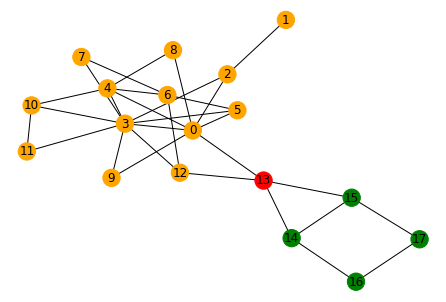

In [5]:
data_model.visualization(0)

#### 2. False

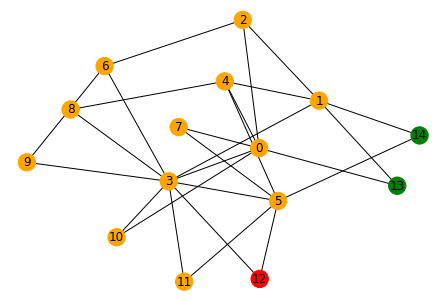

In [6]:
data_model.visualization(1)

GNN-Explainer는 저 집 모양을 탐색해내야 합니다.  
모델은 gnn_explainer라는 .py파일로 구현되어 있습니다.  
전체적인 결과를 확인해보겠습니다.

## 1. Training  Model

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
# Network generating
from network_generator2 import *

# Defining model 
from GNN_models import *

# Defining GNN-Explainer
from gnn_explainer import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1.1. Generate data

In [2]:
data_model = BA_house_generator(max_n= 15, 
                          min_n = 10, 
                          edge_rate = 2,
                          data_type = "single_house",
                          r_seed = 0)

In [3]:
data_model.dataset_generator(num_graph = 5000)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4064.13it/s]


In [4]:
data_module = DataLoader(data_model.data_list, batch_size = 10)

### 1.2. Define GNN models & Train

GNN 모델을 생성합니다.  
GNN architecture는 GCN를 사용하였고, 층은 16차원짜리 하나만 쌓습니다.

In [10]:
model = house_classifier(dataset = data_model.data_list[0], latent_dim = [16]).to(device)

In [11]:
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model.train()
for epoch in range(50):
    for data in data_module : 
        data.to(device)
        optimizer.zero_grad()
        out = model(data = data, training_with_batch = True, in_shape = "normal")
        loss = F.binary_cross_entropy(out.view(-1), data.y)
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0 : 
        print("Epoch : {0} / Loss : {1}".format(epoch, loss.to("cpu").item()))

Epoch : 0 / Loss : 0.16047780215740204
Epoch : 5 / Loss : 0.08094092458486557
Epoch : 10 / Loss : 0.05468260124325752
Epoch : 15 / Loss : 0.030398685485124588
Epoch : 20 / Loss : 0.016090916469693184
Epoch : 25 / Loss : 0.009143615141510963
Epoch : 30 / Loss : 0.0066325175575912
Epoch : 35 / Loss : 0.0052882530726492405
Epoch : 40 / Loss : 0.004604618065059185
Epoch : 45 / Loss : 0.004000774119049311


Loss가 잘 떨어지는 것이 확인가능합니다.  
이제 test data에 대해 적용해보겠습니다.

### Testing Accuracy

In [12]:
test_model = BA_house_generator(max_n= 30, 
                          min_n = 20, 
                          edge_rate = 2,
                          data_type = "single_house",
                          r_seed = 5000)
test_model.dataset_generator(num_graph = 1000)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3423.89it/s]


In [13]:
model.to(device)
acc = 0
for i in range(len(test_model.data_list)) : 
    new_d = test_model.data_list[i].to(device)
    y_hat = model(data = new_d, 
         training_with_batch = False, 
                 in_shape = "basic")
    if y_hat > 0.5 : pred = 1
    else : pred = 0
    if pred == test_model.data_list[i].y.item() : 
        acc += 1

In [14]:
acc/1000

1.0

정확도 1.0으로 완벽하게 분류하는 것을 확인할 수 있습니다.  
이 데이터와 모델을 GNN-Explainer나 PG-Explainer에 활용할 수 있겠습니다.

----------

## 2. Explain model

이제 GNN-Explainer를 아래 instance에 대해 학습시켜보겠습니다.  
Explainer는 집 모양을 추출해야합니다.

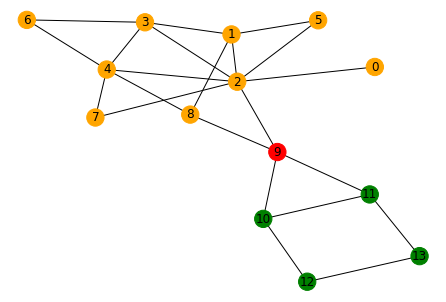

In [15]:
data_model.visualization(50)

Now in epoch 400 / Estimated important subgrph is




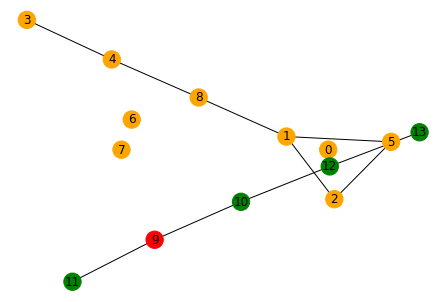



Now in epoch 800 / Estimated important subgrph is




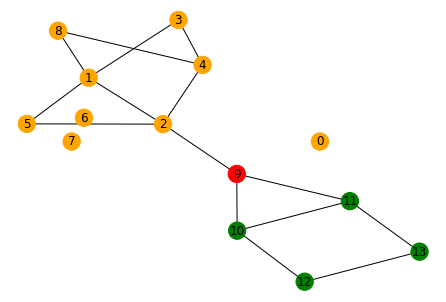



Now in epoch 1200 / Estimated important subgrph is




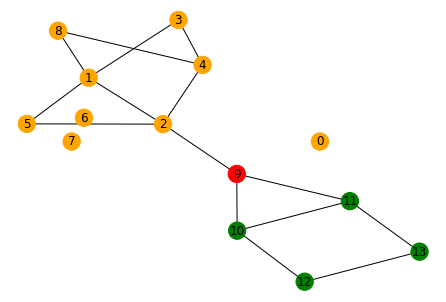



Now in epoch 1600 / Estimated important subgrph is




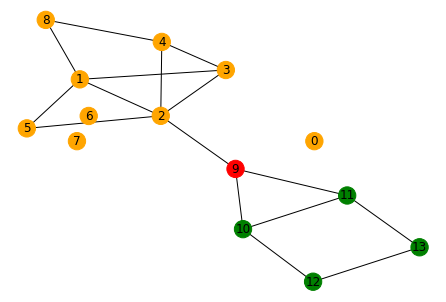



Now in epoch 2000 / Estimated important subgrph is




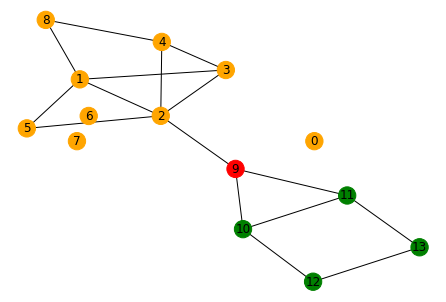



Finished!!


In [23]:
explainer = gnn_explainer(data = data_model.data_list[50], GNN = model, device = device)
explainer = explainer.to(device)
lr = 0.001
explainer.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = explainer()
    loss = F.binary_cross_entropy(explainer().view(-1), torch.tensor([1], dtype = torch.float).to(device))
    loss += (torch.sum((explainer.adj_masking))**2)
    loss.backward(retain_graph = True)
    explainer.adj_masking -= lr*explainer.adj_masking.grad
    
    if (epoch+1) % 400 == 0 : 
        print("Now in epoch {0} / Estimated important subgrph is".format(epoch + 1))
        print("\n")
        result_generator(data = data_model.data_list[50], 
                adj_mask = explainer.adj_masking, 
                feature_mask = explainer.feat_masking, 
                threshold = 0.5)
        print("\n")
           
print("Finished!!")

-----------

## 3. Checking result

원 그래프입니다. 

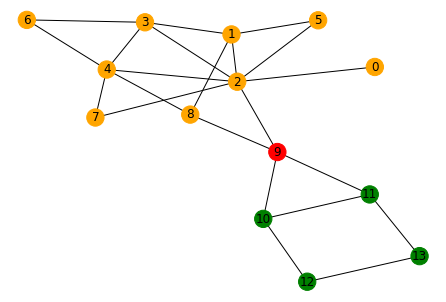

In [26]:
data_model.visualization(50)

추출된 중요 그래프입니다.  
threshold는 0.507로 설정하였습니다.

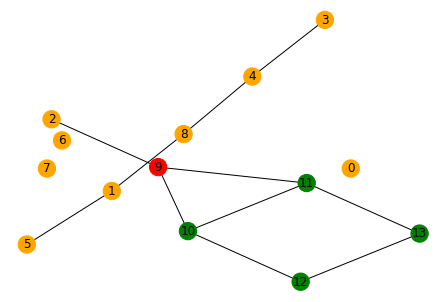

In [35]:
result_generator(data = data_model.data_list[50], 
                adj_mask = explainer.adj_masking, 
                feature_mask = explainer.feat_masking, 
                threshold = 0.507)

완전히 집 모양만 추출하지는 못했지만, 추출된 중요 부분에 집 모양이 포함된 것을 확인할 수 있습니다.